
# Fraud Detection Analysis

Author: Michio Suginoo

In this notebook, I will explore three approaches to predict default cases in a credit card dataset. Since fraud cases are rare, they constitute a minority class. In order to predict fraud cases efficiently, we need to have an approach to better address an imbalanced dataset.

The three approaches that I selected are:
1. A Simple Ensemble Method
2. An Ensemble Method with GAN (Generative Adversarial Networks) to simulate realistic fake fraude cases.


I selected ther following dataset of credit card transactions from
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In total the dataset contains
The dataset contains 284,807 transactions. In the dataset, there are 492 frauds cases.

I selected this dataset because of the following reasons.
*   Fraud cases account for only 0.172% of all transactions.
*   It is a finance related dataset.

This dataset is appropriate for classification analysis of imbalanced dataset in the context of finance.   

It has 30 features.

   * V1, V2, ... V28: the principal components obtained with PCA. The source of the data is not disclosed for the privacy protection purpose.
   * 'Time': the seconds elapsed between each transaction and the first transaction in the dataset.
   * 'Amount': the transaction Amount.

The label is set as 'Class'.
   * 'Class': 1 in case of fraud; and 0 otherwise.


## Step 0: Configuration of Colab Notebook and Installation of relevant API.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 15 21:11:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
import pandas as pd
import numpy as np

In [4]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [5]:
#!pip install pandas==2.0.3
!pip install vision-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.7/164.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but y

In [6]:
!pip install --upgrade pandas ydata-profiling typing-extensions


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.8/357.8 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 28.6 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=5efa0d77224b0aadb71fa9b852474691f07edcd2d4af54029064ad76b8767668
  S

# <font color=red>Caution: Please do the following
Stop and Restart RUNTIME. Then run the code after this cell. </font>


In [7]:
Stop and Restart RUNTIME
Then run the code after this cell.

SyntaxError: invalid syntax (<ipython-input-7-c4b5543e7d17>, line 1)

# Step 1: Retrieve Dataset

I selected Credit Card Fraud dataset from the following link of Kaggle. I use Kaggle API to download it: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [1]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 86% 57.0M/66.0M [00:00<00:00, 128MB/s]
100% 66.0M/66.0M [00:00<00:00, 119MB/s]


In [3]:
!unzip /content/creditcardfraud.zip

Archive:  /content/creditcardfraud.zip
  inflating: creditcard.csv          


In [4]:
import pandas as pd
import numpy as np
DATA=pd.read_csv("/content/creditcard.csv")

In [5]:
DATA.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# Check the missing values
DATA.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

# Step 2: Data Preprocessing

## 1. Removal of Duplicated Data.

I will address the dupulicated data problems here.

In [7]:
#Check the shape of the dataset
DATA.shape

(284807, 31)

In [8]:
df=DATA.drop_duplicates()

In [9]:
df.shape

(283726, 31)

In [10]:
# Check the number of duplicate observations removed.
DATA.shape[0]-df.shape[0]

1081

## 2. Profile Report

I use ydata_profiling ProfileReport for summarizing dataset.


In [11]:
from ydata_profiling import ProfileReport


Since I encountered difficulties in displaying the result of the profile report, I decided to export the result to a html file in the following cell. Please open it in a browser. I apologize for any inconvenience arising from this.

In [12]:
report_raw = ProfileReport(df)
report_raw.to_file('profile_report_raw.html')

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3.  Define the outliers:
Based on the profile report displayed in the html file, I selected the following lower and upper percentile thresholds to detect outliers.


In [13]:
lp = 0.05
up = 99.95

In [14]:
lower_percentile_thresholds ={"V1": lp, "V2": lp, "V3": lp, "V4": 0, "V5": lp, "V6": 0, "V7": 0, "V8": lp, "V9": 0, "V10": 0, "V11": 0, "V12": lp, "V13": 0, "V14": lp, "V15": 0, "V16": 0, "V17": 0, "V18": lp, "V19": 0, "V20": 0, "V21": 0, "V22": 0, "V23": lp, "V24": 0, "V25": lp, "V26": 0, "V27": 0, "V28": 0, "Amount":0}

In [15]:
len(lower_percentile_thresholds)

29

In [16]:
upper_percentile_thresholds ={"V1": 100, "V2": 100, "V3": 100, "V4": up, "V5": 100, "V6": up, "V7": up, "V8": 100, "V9": up, "V10": 100, "V11": up, "V12": 100, "V13": up, "V14": 100, "V15": 100, "V16": 100, "V17": 100, "V18": 100, "V19": 100, "V20": 100, "V21": 100, "V22": 100, "V23": 100, "V24": up, "V25": 100, "V26": 100, "V27": 100, "V28": up,"Amount":up}

In [17]:
len(upper_percentile_thresholds)

29

In [18]:
# Dictionary to store outliers for each feature
outliers_dict = {}

# Step 1: Detect Outliers using Percentiles
for feature, lower_percentile in lower_percentile_thresholds.items():
    # Calculate the lower percentile threshold for the feature
    lower_threshold = np.percentile(df[feature], lower_percentile)

    # Calculate the upper percentile threshold for the feature
    upper_percentile = upper_percentile_thresholds[feature]
    upper_threshold = np.percentile(df[feature], upper_percentile)

    # Identify outliers for the current feature for Class 0 and Class 1 separately
    outliers_0 = df[((df[feature] < lower_threshold) | (df[feature] > upper_threshold)) & (df['Class'] == 0)]
    outliers_1 = df[((df[feature] < lower_threshold) | (df[feature] > upper_threshold)) & (df['Class'] == 1)]

    # Store outliers in the dictionary
    outliers_dict[feature] = {
        'Class_0': outliers_0,
        'Class_1': outliers_1
    }

In [19]:
# Step 2: Remove Outliers except for Class 1
filtered_data = df.copy()  # Make a copy to keep original intact

for feature in outliers_dict:
    # Remove outliers for Class 0
    filtered_data.loc[outliers_dict[feature]['Class_0'].index, feature] = np.nan

# Drop rows with NaN values after handling outliers
filtered_data.dropna(inplace=True)

Let's check the change made in terms of shapes.

In [20]:
filtered_data.shape

(282513, 31)

In [21]:
filtered_data[filtered_data["Class"]==1].shape

(473, 31)

In [22]:
df[df["Class"]==1].shape

(473, 31)

In [23]:
DATA.shape

(284807, 31)

Check how many rows were removed.

In [24]:
df.shape[0]-filtered_data.shape[0]

1213

How much % of the original data was removed?

In [25]:
(df.shape[0]-filtered_data.shape[0])/df.shape[0]

0.0042752514750146265

## 5.  Feature Selection

 We can use SelectFromModel feature selection function to run Random Forest to generate the feature importance. </ font>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel



In [26]:
X = filtered_data.drop(columns=["Class"])
y = filtered_data["Class"]

In [27]:
# the shape of the feature dataframe
X.shape

(282513, 30)

In [28]:
# the shape of the label dataframe
y.shape

(282513,)

In [29]:
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
import os # accessing directory structure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [30]:
X.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [31]:
# Train the model
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(X)
scaled_X=pd.DataFrame(scaled_array, columns = X.columns)
scaled_X.shape

(282513, 30)

In [32]:
scaled_X.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

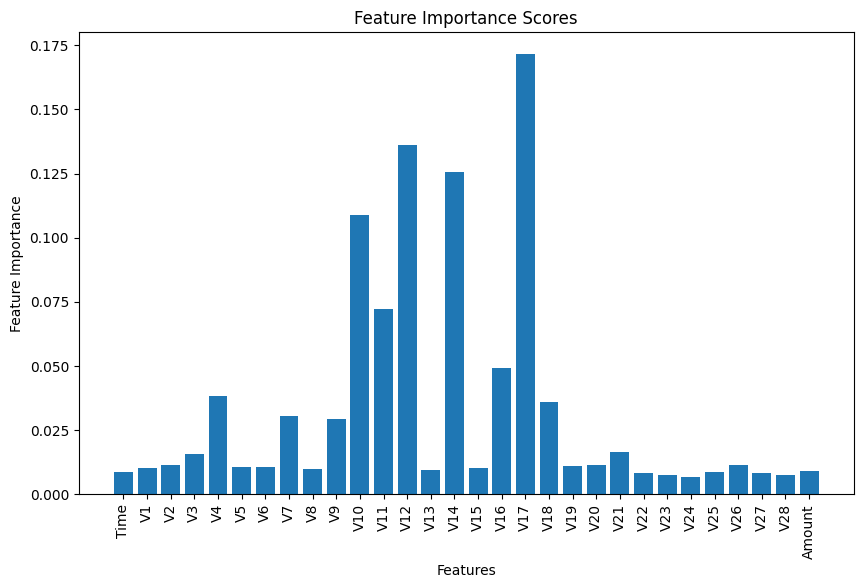

In [33]:


from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(scaled_X, y)
feature_importances = model.feature_importances_

# Plot a bar chart of feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=X.columns)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Feature Importance Scores")
plt.show()


In [34]:
# Select the number of features that I want to retain from the result of the Feature Importance Score.
top_feature_num = 6

In [35]:
from sklearn.feature_selection import SelectFromModel

# Sort feature importances in descending order
sorted_feature_importances = sorted(enumerate(feature_importances), key=lambda x: x[1], reverse=True)

# Get the top feature indices
selected_indices = [index for index, _ in sorted_feature_importances[:top_feature_num]]

# Apply the threshold for feature selection
selector = SelectFromModel(model, threshold=-float('inf'), max_features=top_feature_num)  # Use -inf to select top features
selected_features = selector.fit_transform(scaled_X, y)


In [36]:
#
selected_feature_indices = selector.get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = scaled_X.columns[selected_feature_indices]

selected_feature_names

Index(['V10', 'V11', 'V12', 'V14', 'V16', 'V17'], dtype='object')

In [37]:
type(selected_feature_names)

pandas.core.indexes.base.Index

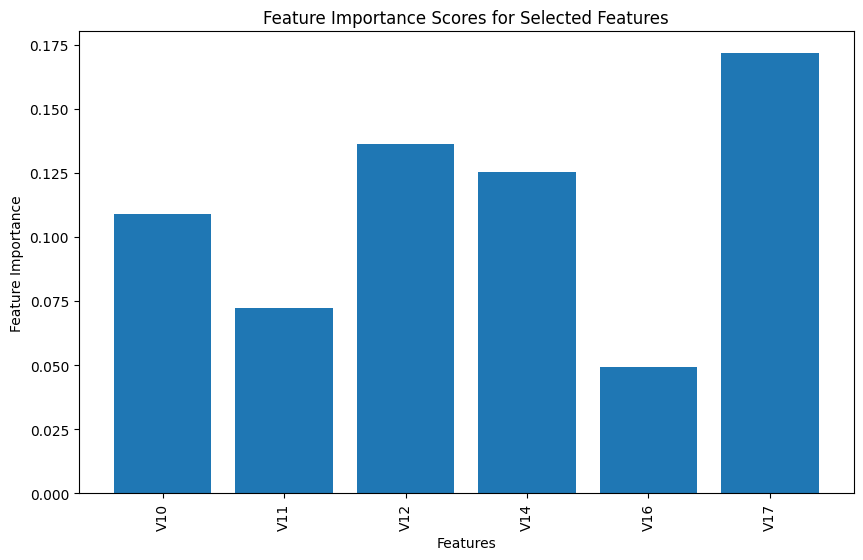

In [38]:
import matplotlib.pyplot as plt

# Filter feature importances for the selected features
selected_feature_indices = [X.columns.get_loc(feature) for feature in selected_feature_names]
selected_feature_importances = [feature_importances[i] for i in selected_feature_indices]

# Create a bar chart of feature importances for the selected features
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_feature_names)), selected_feature_importances)
plt.xticks(range(len(selected_feature_names)), selected_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Feature Importance Scores for Selected Features")
plt.show()


In [39]:
type(selected_feature_names)

pandas.core.indexes.base.Index

In [40]:
selected_features = selected_feature_names.tolist()
selected_features

['V10', 'V11', 'V12', 'V14', 'V16', 'V17']

In [41]:
Keep=selected_features+['Class']
df=filtered_data.filter(Keep)

In [42]:
df.head()

,V10,V11,V12,V14,V16,V17,Class
0,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0
1,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,0
2,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,0
3,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,0
4,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,0


In [43]:
df.shape

(282513, 7)

##  Save the preprocessed dataframe, "wdf", in CSV file.


In [44]:
df.to_csv('fraud_wdf.csv', index=False)

# Step 3: Model Development: 3 Scenarios

I run three scenarios below to compare their performances.

* Scenario 1.   Ensemble
* Scenario 2.   SMOTE y Ensemble
* Scenario 3. GAN y Ensemble


## A. Scenario 1.   Ensemble

I selected the following 3 algorithms as base learner.


1.   Gradient Boosting
2.   Decision Tree
3. Random Forest


And I selected Voting Method for the meta learner.




In [45]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.7 MB/s eta 0:00:00


In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from scipy.stats import uniform

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score


In [47]:

# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']


In [48]:
X.shape

(282513, 6)

In [49]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np


def ensemble_training(X_train, y_train):

  # Initialize base learners
  gradient_boosting = GradientBoostingClassifier(random_state=42)
  decision_tree = DecisionTreeClassifier(random_state=42)
  random_forest = RandomForestClassifier(random_state=42)

  # Define the base models
  base_models = {
    'RandomForest': random_forest,
    'DecisionTree': decision_tree,
    'GradientBoosting': gradient_boosting
  }

  # Initialize the meta learner
  meta_learner = VotingClassifier(estimators=[(name, model) for name, model in base_models.items()], voting='soft')

  # Lists to store training and validation metrics
  train_f1_scores = []
  val_f1_scores = []

  # Splitting the train set further into training and validation sets
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

  # Training and validation
  for model_name, model in base_models.items():
    model.fit(X_train, y_train)

    # Training metrics
    train_predictions = model.predict(X_train)
    train_f1 = f1_score(y_train, train_predictions)
    train_f1_scores.append(train_f1)

    # Validation metrics using the validation set
    val_predictions = model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions)
    val_f1_scores.append(val_f1)

  # Training the meta learner on the entire training set
  meta_learner.fit(X_train, y_train)

  return meta_learner, train_f1_scores, val_f1_scores, base_models

def ensemble_visualization(base_models, train_f1_scores, val_f1_scores):
  # Visualization of training and validation metrics
  plt.figure(figsize=(10, 6))
  models = list(base_models.keys())
  x = np.arange(len(models))
  bar_width = 0.35
  plt.bar(x, train_f1_scores, width=bar_width, label='Train F1-score')
  plt.bar(x + bar_width, val_f1_scores, width=bar_width, label='Validation F1-score')
  plt.xlabel('Models')
  plt.ylabel('F1-score')
  plt.title('Training and Validation F1-score for Base Learners')
  plt.xticks(x + bar_width // 2, models)
  plt.legend()
  plt.tight_layout()
  plt.show()

def ensemble_evaluations(meta_learner,X_train, y_train, X_test, y_test):
# Metrics for the ensemble model on both training and test datasets
  ensemble_train_predictions = meta_learner.predict(X_train)
  ensemble_test_predictions = meta_learner.predict(X_test)

  # Calculating metrics for the ensemble model
  ensemble_train_f1 = f1_score(y_train, ensemble_train_predictions)
  ensemble_test_f1 = f1_score(y_test, ensemble_test_predictions)

  # Calculate precision and recall for both training and test datasets
  precision_train = precision_score(y_train, ensemble_train_predictions)
  recall_train = recall_score(y_train, ensemble_train_predictions)

  precision_test = precision_score(y_test, ensemble_test_predictions)
  recall_test = recall_score(y_test, ensemble_test_predictions)


  # Output precision, recall, and f1 score for both training and test datasets
  print("Ensemble Model Metrics:")
  print(f"Training Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1-score: {ensemble_train_f1:.4f}")
  print(f"Test Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-score: {ensemble_test_f1:.4f}")

  return ensemble_train_predictions, ensemble_test_predictions, ensemble_train_f1, ensemble_test_f1, precision_train, recall_train, precision_test, recall_test


In [51]:
meta_learner, train_f1_scores, val_f1_scores, base_models=ensemble_training(X_train, y_train)

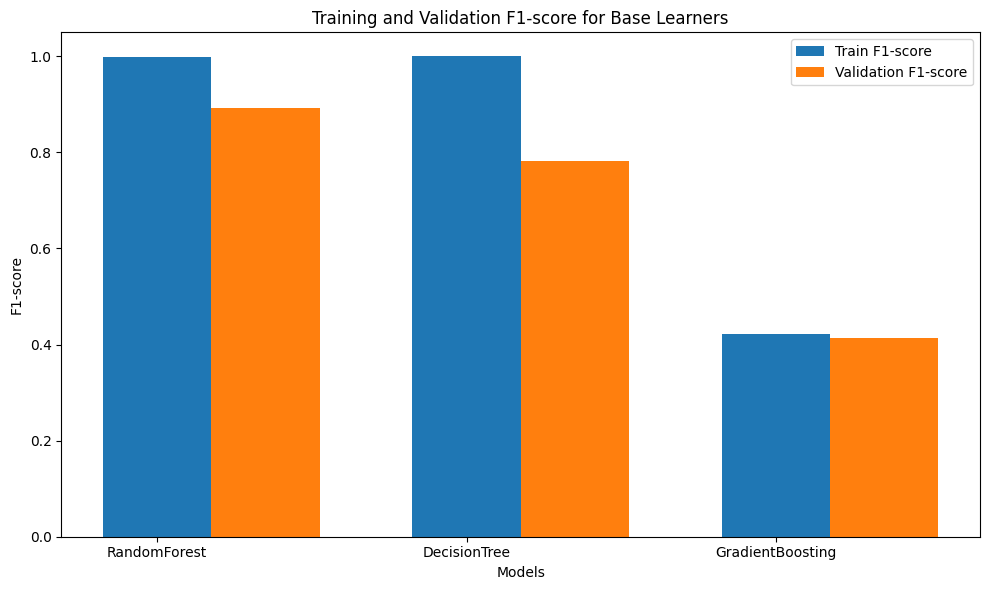

In [52]:
ensemble_visualization(base_models, train_f1_scores, val_f1_scores)

In [53]:
ensemble_evaluations(meta_learner,X_train, y_train, X_test, y_test)

Ensemble Model Metrics:
Training Precision: 0.9811, Recall: 0.9603, F1-score: 0.9706
Test Precision: 0.9351, Recall: 0.7579, F1-score: 0.8372


(array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 0.9705882352941175,
 0.8372093023255814,
 0.981081081081081,
 0.9603174603174603,
 0.935064935064935,
 0.7578947368421053)


## B. Scenario 2: GAN & Ensemble

The dataset was split using stratified method between the train dataset and the test dataset. In order to preserve the original state of the test dataset, fraud data, I will apply GAN only on the minority class in the training dataset to augument.

Then, I will conduct Ensemble with augumented balanced data.

In this way, we can evaluate the predicting power of the model using the preserved original test dataset.  


In [54]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [55]:
X_train.shape

(226010, 6)

In [56]:
X_test.shape

(56503, 6)

In [57]:
train_df = pd.concat([X_train, y_train], axis=1)

In [58]:
train_df.shape

(226010, 7)

In [59]:
import numpy as np
from keras.layers import Dense, Input
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K

# Load the dataset (fraud and non-fraud data)
# Assuming df contains the dataset with columns including 'Class' and other features
fraud_data = train_df[train_df['Class'] == 1].drop('Class', axis=1).values
non_fraud_data = train_df[train_df['Class'] == 0].drop('Class', axis=1).values


In [60]:
# Calculate the number of synthetic fraud samples to generate
num_real_fraud = len(fraud_data)
num_synthetic_samples = len(non_fraud_data) - num_real_fraud
print("# of non-fraud: ", len(non_fraud_data))
print("# of Real Fraud:", num_real_fraud)
print("# of Synthetic Fraud required:", num_synthetic_samples)

# of non-fraud:  225632
# of Real Fraud: 378
# of Synthetic Fraud required: 225254


## GAN: Model Building & Training

I use GAN to generate fake but realistic data for the minority class, fraud. GAN has two sub-models: generator and discriminator.
While generator creates fake data. discriminator intends to distinguish between fake data and real data.

Since I encountered some difficulties in accessing Google Colab's GPU, I decided to omit the hyperparameter optimization for this time.

### Bi-Level Optimization

In order to optimize these two built-in models, GANs applies the framework of ‘bi-level optimization’.

As the name suggests, bi-level optimization has two levels: the upper-level optimization and the lower-level optimization. The lower-level optimization is nested within the upper-level optimization. (Wikipedia, 2023)

In the case of GANs, the discriminator is optimized in the lower-level, while the generator is optimized (together with the discriminator) in the upper-level.


In [61]:
# Define the generator network
def build_generator(latent_dim, output_dim):
    model = Sequential()
    model.add(Dense(64, input_shape=(latent_dim,)))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(output_dim, activation='sigmoid'))
    return model


# Define the discriminator network
def build_discriminator(input_dim):
    model = Sequential()
    model.add(Input(input_dim))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Dimensionality of the input noise for the generator
latent_dim = 32

# Build generator and discriminator models
generator = build_generator(latent_dim, fraud_data.shape[1])
discriminator = build_discriminator(fraud_data.shape[1])

# Display model summaries
print("Generator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()


Generator Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 11206 (43.77 KB)
Trainable params: 11206 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Discriminator Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               896       
                     

### Compile the discriminator sub-model:
I selected Precision and Recall for the metrics argument.

In [62]:
# Compile the discriminator model
from keras.metrics import Precision, Recall
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy',  metrics=[Precision(), Recall()])


### Custom Loss Function for Generator:

In order to determine the loss function (objective function), I followed the method outlined in the original GAN paper.


>   "Early in learning, when G is poor can reject samples with high confidence because they are clearly different from the training data. In this case, log(1−D(G(z)))saturates. Rather than training G to minimize log(1−D(G(z)) we can train G to maximize logD(G(z))."

> Title: "Generative Adversarial Networks"

> Authors: Ian Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio

> Source: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1406.2661.pdf

The method is described in the page 3 of the paper.
Here are two precautions:
*  model.optimize() is designed to minimize the objective function. So, I have to convert the function, logD(G(z)), with negative sign for the definition of the objective function.
* we use this custom loss function of generator only when we compile the meta-model of GAN. Remember, we do not compile the generrator in the architecture of GAN.


In [63]:
def generator_loss_log_d(y_true, y_pred):
    return -K.mean(K.log(y_pred + K.epsilon()))



In [64]:
# GAN model combining generator and discriminator
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss=generator_loss_log_d)

    return model

# Build and compile the GAN model
gan = build_gan(generator, discriminator)


Batch Training

In [65]:
# Set hyperparameters
epochs = 10000
batch_size = 32

# Training loop for the GAN
for epoch in range(epochs):
    # Train discriminator (freeze generator)
    discriminator.trainable = True
    generator.trainable = False

    # Select random real fraud samples
    real_fraud_samples = fraud_data[np.random.randint(0, num_real_fraud, batch_size)]

    # Generate fake fraud samples using the generator
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    fake_fraud_samples = generator.predict(noise)

    # Create labels for real and fake fraud samples
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train the discriminator on real and fake fraud samples
    d_loss_real = discriminator.train_on_batch(real_fraud_samples, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_fraud_samples, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator (freeze discriminator)
    discriminator.trainable = False
    generator.trainable = True

    # Generate fake fraud samples and create labels for training the generator
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))

    # Train the generator to generate samples that "fool" the discriminator
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Print the progress
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} - D Loss: {d_loss} - G Loss: {g_loss}")

# After training, use the generator to create synthetic fraud data
noise = np.random.normal(0, 1, size=(num_synthetic_samples, latent_dim))
synthetic_fraud_data = generator.predict(noise)


ストリーミング出力は最後の 5000 行に切り捨てられました。
1/1 [==============================] - 0s 19ms/step
Epoch: 5100 - D Loss: [0.04250325 0.5        0.5       ] - G Loss: 2.789276123046875
1/1 [==============================] - 0s 19ms/step
Epoch: 5200 - D Loss: [0.05479842 0.5        0.484375  ] - G Loss: 2.7435483932495117
1/1 [==============================] - 0s 18ms/step
Epoch: 5300 - D Loss: [0.0353788 0.5       0.5      ] - G Loss: 2.7866220474243164
1/1 [==============================] - 0s 19ms/step
Epoch: 5400 - D Loss: [0.11663603 0.5        0.484375  ] - G Loss: 2.8192992210388184
1/1 [==============================] - 0s 19ms/step
Epoch: 5500 - D Loss: [0.05019  0.5      0.484375] - G Loss: 2.8155951499938965
1/1 [==============================] - 0s 24ms/step
Epoch: 5600 - D Loss: [0.06796764 0.5        0.484375  ] - G Loss: 2.860274314880371
1/1 [==============================] - 0s 22ms/step
Epoch: 5700 - D Loss: [0.06498491 0.5        0.484375  ] - G Loss: 2.7861435413360596
1/1 [========

In [66]:
type(synthetic_fraud_data)

numpy.ndarray

In [67]:
synthetic_fraud_data.shape

(225254, 6)

In [68]:
features = df.columns[:-1]
features

Index(['V10', 'V11', 'V12', 'V14', 'V16', 'V17'], dtype='object')

In [69]:
type(features)

pandas.core.indexes.base.Index

In [70]:
fake_df = pd.DataFrame(synthetic_fraud_data, columns=features.to_list())

In [71]:
fake_df["Class"] = 1

In [72]:
fake_df.shape

(225254, 7)

In [73]:
df.shape

(282513, 7)

In [74]:
wdf = pd.concat([df, fake_df], axis=0)

# Resetting the index of the new DataFrame
wdf.reset_index(drop=True, inplace=True)


In [75]:
wdf.shape

(507767, 7)

## 2. Binary Classification with Ensemble

Here, I combine the real training dataset and the fake fraud dataset.

The resulting dataset is divided into its feature dataset, X_mixed, and its label, y_mixed. These datasets are used for training the Ensemble Tree.

Here, I will call the custom function, ensemble_training(), to train a binary classification model.

Thereafter, the fitted model is going to be used for testing with the original X_test and y_test.

In [76]:

X_mixed = wdf[wdf.columns.drop("Class")]
y_mixed = wdf["Class"]


In [77]:
meta_learner_gan, train_f1_scores_gan, val_f1_scores_gan, base_models_gan=ensemble_training(X_mixed, y_mixed)

In [78]:
meta_learner_gan

VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(random_state=42)),
                             ('DecisionTree',
                              DecisionTreeClassifier(random_state=42)),
                             ('GradientBoosting',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

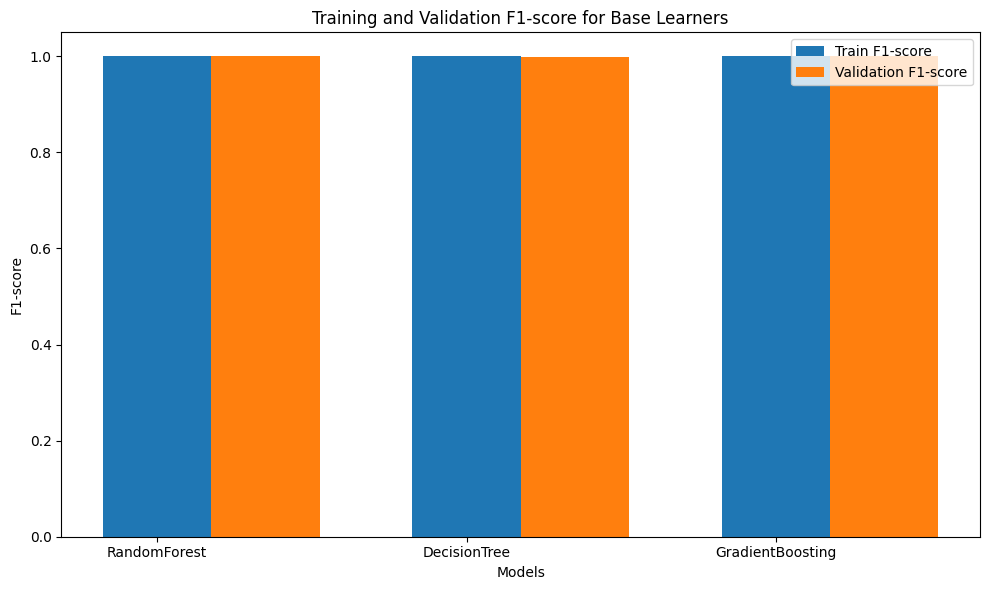

In [79]:
ensemble_visualization(base_models_gan, train_f1_scores_gan, val_f1_scores_gan)

For the testing, we pass the original X_test, y_test

In [80]:
ensemble_evaluations(meta_learner_gan, X_mixed, y_mixed, X_test, y_test)

Ensemble Model Metrics:
Training Precision: 1.0000, Recall: 0.9999, F1-score: 0.9999
Test Precision: 0.9574, Recall: 0.9474, F1-score: 0.9524


(array([0, 0, 0, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 0, 0, 0]),
 0.9999424060110403,
 0.9523809523809523,
 0.9999822780660054,
 0.9999025371355664,
 0.9574468085106383,
 0.9473684210526315)

# Step 4: Conclusion

Overall, Ensemble with GAN (F1 Score: 0.9524) yielded the better test performance than the benchmark scenario (F1-score: 0.8372).